# Probmods: Chapter 2

In this notebook I will translate a selection of the example code snippets from the probmods book into numpyro. The original book is written using webPPL, and is available at https://probmods.org/.

In [672]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import SA, MCMC, Predictive, NUTS, DiscreteHMCGibbs

import numpy as np
import jax.numpy as jnp
import jax

import seaborn as sns
from functools import partial

In [92]:
def flip(p=None):
    if p==None: p=.5
    return numpyro.sample("coin", dist.Bernoulli(jnp.array(p)))

We can define functions just like that but there is no global state in `numpyro` so we can't just call our function without passing it a `PRNGKey` that specifies the state of the random number generator. Unfortunately that mucks with the syntax quite a bit, making things very unlike `webPPL`. For the simple examples here, my solution is to just create some kludgy wrapper functions to use the old-school numpy random number generator. 

I'm creating a function `make_random()` that takes a function and returns a version of it wrapped in `handlers.seed()` with a randomly initialized `PRNGKey()`. This little function won't behave properly inside of a true program doing inference, but it's useful for these examples. 

So what we do is 1) define a probabilistic function we want, 2) pass that function into the `make_random()` function to create stochastic version of it. I'll use the convention of adding an `_` to the function names for the random version, so `flip() --> _flip()` below.

In [668]:
def make_random(fn):
    key = jax.random.PRNGKey(np.random.randint(0, 1e6))
    return handlers.seed(fn, rng_seed=key)

_flip = make_random(flip)

_flip(.5)

DeviceArray(1, dtype=int32)

Often we want to call our stochastic function many times to observe its behavior. I've created a wrapper `repeat_func()` to do this and munge some vector shapes.

<AxesSubplot:ylabel='Count'>

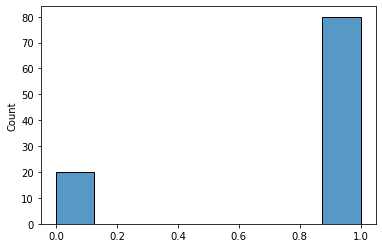

In [669]:
def repeat_func(n, fn, *args):
    return jnp.stack([fn(*args) for _ in range(0,n)])

sns.histplot(repeat_func(100, _flip, .8))

Outside an inference context, the stochastic `_flip()` behaves just like the webPPL `flip()`

In [670]:
_flip() + _flip() + _flip()

DeviceArray(2, dtype=int32)

<AxesSubplot:ylabel='Count'>

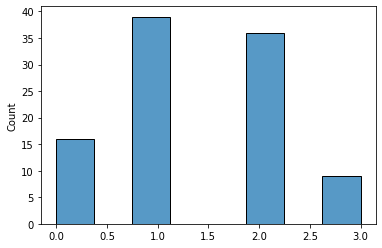

In [671]:
def sumFlips():
    return _flip() + _flip() + _flip()

sns.histplot(repeat_func(100, sumFlips))

We can use the `partial()` python function to create stochastic functions with fixed arguments.

In [673]:
lungCancer = partial(_flip,.01)
TB = partial(_flip,.005)
stomachFlu = partial(_flip,.1)
cold = partial(_flip,.2)
other = partial(_flip,.1)

cough = (cold and _flip(.5)) or (lungCancer and _flip(.3)) or (TB and _flip(.7)) or (other and _flip(.01))

fever = (cold and _flip(.3)) or (stomachFlu and _flip(.5)) or (TB and _flip(.1)) or (other and _flip(.01))

chestPain = (cold and _flip(.5)) or (TB and _flip(.5)) or (other and _flip(.01))

shortnessOfBreath = (lungCancer and _flip(.5)) or (TB and _flip(.2)) or (other and _flip(.01))

symptoms = {"cough":cough, "fever":fever, "chestPain":chestPain, "shortnessOfBreath":shortnessOfBreath }

symptoms

{'cough': DeviceArray(1, dtype=int32),
 'fever': DeviceArray(1, dtype=int32),
 'chestPain': DeviceArray(1, dtype=int32),
 'shortnessOfBreath': DeviceArray(1, dtype=int32)}

<AxesSubplot:ylabel='Count'>

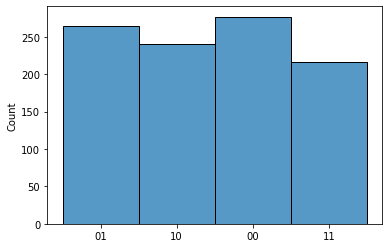

In [674]:
def randomPair():
    return [_flip(), _flip()]

sns.histplot(np.array([ ''.join(map(str,randomPair())) for _ in range(1000)]))

## Constructing marginal distributions: Inference

Now we start doing inference. In webPPL this is handled with a function called `Infer()` that takes a handful of simple arguments. The inference interface in Numpyro is much more capable but also a fair deal more complicated. It is also more difficult to use "simpler" inference approaches: exact enumeration requires some extra syntax and there is no direct implementation of rejection sampling. There is one gradient-free MCMC kernel `SA()` that could be useful for these low-dimensionality discrete models and there is `DiscreteHMCGibbs()` kernel that combines HMC and gibbs sampling for discrete sites that seems to work quite well for low numbers of discrete latent variables.

```javascript
// original webPPL code
//a complex function, that specifies a complex sampling process:
var foo = function(){gaussian(0,1)*gaussian(0,1)}

//make the marginal distributions on return values explicit:
var d = Infer({method: 'forward', samples: 1000}, foo)

//now we can use d as we would any other distribution:
print( sample(d) )
viz(d)
```

When dealing with deterministic variables (including variables that are deterministic combinations of random variables—Stan woul call these "transformed parameters"), we have to use the `numpyro.deterministic()` function to mark them in side the model, and use a `Predictive()` object to view them. That's potentially one reason to use the `Predictive()` by default.

sample: 100%|██████████| 2000/2000 [00:02<00:00, 969.43it/s, acc. prob=0.58] 


<AxesSubplot:ylabel='Density'>

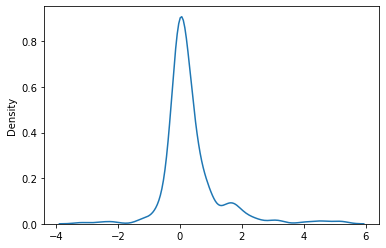

In [549]:
key = jax.random.PRNGKey(0)

def foo():
    a = numpyro.sample("a", dist.Normal(jnp.array(0.), jnp.array(1.)))
    b = numpyro.sample("b", dist.Normal(jnp.array(0.), jnp.array(1.)))
    numpyro.deterministic("query", a*b)

    return None

posterior = MCMC(DiscreteHMCGibbs(NUTS(model)))
posterior.run(key)

posterior_samples = posterior.get_samples()

# to get the deterministic sites, have to create Predictive() object
posterior_predictive = Predictive(foo, posterior_samples)
sns.kdeplot(posterior_predictive.posterior_samples["query"])


In `numpyro` the return values of the model function don't really do anything, so we have to explicitly mark the deterministic site for $a \cdot b$.

## Stochastic recursion

Skipping ahead a bit, we reach a recursive implementation of the geometric distribution. This is our first illustration of the extra bookkeeping needed in Pyro. Here, it means we can't just reuse our `flip()` function inside this recursive function.

```javascript
// original webPPL code
var geometric = function (p) {
    flip(p) ? 0 : 1 + geometric(p);
};
var g = Infer({method: 'forward', samples: 1000},
              function(){return geometric(0.6)})
viz(g)
```

<AxesSubplot:ylabel='Count'>

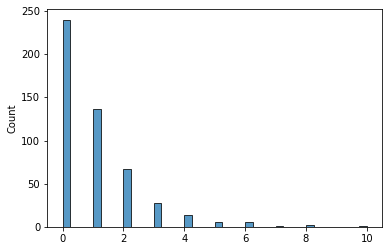

In [645]:
# this is the most webPPL-esque approach but it only works outside of inference

def _geometric(p, t=None):
    if t is None:
        t = 0
        
    x = _flip(p)
    
    return jnp.array(0) if x==1 else 1 + _geometric(p, t + 1)


sns.histplot(repeat_func(500, _geometric, .5))

## this would work inside an inference

# this needs a bit of extra book-keeping so we can't just reuse flip() function
# here we need to pass both a counter to create unique site names
# as well as PRNGKey to advance the state of randomness

# def geometric(p, key, t=None):
#     if t is None:
#         t = 0
#     x = numpyro.sample("x_{}".format(t), dist.Bernoulli(p), rng_key=key)
    
#     key, subkey = jax.random.split(key)
#     if x == 1:
#         return jnp.array(0)
#     else:
#         return 1 + geometric(p, key, t + 1)

# sns.histplot(jnp.stack([geometric(.6, jax.random.PRNGKey(np.random.randint(1e5))) for _ in range(0,1000)]))